In [1]:
# Import useful modules
import os
import scipy
import random as rand
from scipy import io as sio
from scipy import stats
from scipy.stats.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd


import pickle
import itertools
import time

import copy

import multiprocessing as mp

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import neural_proba
from neural_proba import distrib
from neural_proba import tuning_curve
from neural_proba import voxel
from neural_proba import experiment
from neural_proba import fmri

import utils


### To avoid scrolling windows

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Properties of the models

Here are the properties related to :
- the tuning curves (types, number, variance, ...) both true and fitted. 
- the neural mixture (sparsities)
- the subjects
- the sessions
- the SNR
- the type of linear regression performed

In [5]:
# All parameters are here

# Define the seed to reproduce results from random processes
rand.seed(4);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc', 'rate']
n_schemes = len(scheme_array)

# The parameters related to the tuning curves to be explored

N_array = np.array([2, 3, 4, 5, 6, 7, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.12, 0.1, 8e-2, 7e-2, 6e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.2, 0.15, 0.12, 0.10, 9e-2, 8e-2, 6e-2, 4e-2, 3e-2])

# # Even N
#N_array = np.array([2, 4, 6, 8, 10, 14, 20])

#t_mu_gaussian_array = np.array([0.15, 0.1, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2])
#t_conf_gaussian_array = np.array([0.25, 0.15, 0.10, 8e-2, 6e-2, 4e-2, 3e-2])


t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Lower and upper bounds of the encoded summary quantity (for tuning curves) established from the histograms
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
tc_upper_bound_conf = 2.6

# The number of N to be tested
n_N = len(N_array)

# The number of fractions tested (related to W): one per sparsity level combination
n_fractions = 20

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)

# The number of subjects
n_subjects = 1000

# The number of directions
directions = np.array(list(itertools.product([0,1], repeat=4)))
n_directions = len(directions)

# The number of sessions
n_sessions = 4

# Experimental options
n_stimuli = 380    # The number of stimuli per session

between_stimuli_duration = 1.3
min_break_time = 8
max_break_time = 12
min_n_local_regular_stimuli = 12    # Min number of stimuli before a break
max_n_local_regular_stimuli = 18    # Max number of stimuli before a break


# Transition proba or Bernoulli proba
distrib_type = 'transition'    #'bernoulli' or 'transition' 

# Load the corresponding data
[p1_dist_array, p1_mu_array, p1_sd_array] = neural_proba.import_distrib_param(n_subjects, n_sessions, n_stimuli, distrib_type)

# SNR as defined by ||signal||²/(||signal||²+||noise||²). Mind the squares!
snr = 0.1

# fMRI info
final_frame_offset = 10  # Frame recording duration after the last stimulus has been shown
initial_frame_time = 0
dt = 0.125  # Temporal resolution of the fMRI scanner

between_scans_duration = 2  # in seconds
final_scan_offset = 10  # Scan recording duration after the last stimulus has been shown


# Type of regression
regr = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)
regr2 = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)

whitening_done = False
# All parameters are here

# Define the seed to reproduce results from random processes
rand.seed(4);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc', 'rate']
n_schemes = len(scheme_array)

# The parameters related to the tuning curves to be explored

N_array = np.array([2, 3, 4, 5, 6, 7, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.12, 0.1, 8e-2, 7e-2, 6e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.2, 0.15, 0.12, 0.10, 9e-2, 8e-2, 6e-2, 4e-2, 3e-2])

# # Even N
#N_array = np.array([2, 4, 6, 8, 10, 14, 20])

#t_mu_gaussian_array = np.array([0.15, 0.1, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2])
#t_conf_gaussian_array = np.array([0.25, 0.15, 0.10, 8e-2, 6e-2, 4e-2, 3e-2])


t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Lower and upper bounds of the encoded summary quantity (for tuning curves) established from the histograms
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
tc_upper_bound_conf = 2.6

# The number of N to be tested
n_N = len(N_array)

# The number of fractions tested (related to W): one per sparsity level combination
n_fractions = 20

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)

# The number of subjects
n_subjects = 1000

# Create the matrix with all the possibilities (mu or 1-mu encoded in each session) of size 16x4
n_directions = list(itertools.product([0,1], repeat=4))
n_directions = np.array(n_directions)

# The number of sessions
n_sessions = 4

# Experimental options
n_stimuli = 380    # The number of stimuli per session

between_stimuli_duration = 1.3
min_break_time = 8
max_break_time = 12
min_n_local_regular_stimuli = 12    # Min number of stimuli before a break
max_n_local_regular_stimuli = 18    # Max number of stimuli before a break


# Transition proba or Bernoulli proba
distrib_type = 'transition'    #'bernoulli' or 'transition' 

In [6]:
## Just for now 
n_subjects = 1000

## Handle the data

### Raw data loading and visualization


In [38]:
# Some reloading (one should run it if the loops have already been performed and results saved)
r2_raw_train = np.load(f'/volatile/bounmy/output/results2/snr0.1/{distrib_type}2/all/{n_subjects}subjects_r2_raw_train_snr0.1.npy')
rho_raw_train = np.load(f'/volatile/bounmy/output/results2/snr0.1/{distrib_type}2/all/{n_subjects}subjects_rho_raw_train_snr0.1.npy')
r2_true_train = np.load(f'/volatile/bounmy/output/results2/snr0.1/{distrib_type}2/all/{n_subjects}subjects_r2_true_train_snr0.1.npy')
rho_true_train = np.load(f'/volatile/bounmy/output/results2/snr0.1/{distrib_type}2/all/{n_subjects}subjects_rho_true_train_snr0.1.npy')

r2_raw_test = np.load(f'/volatile/bounmy/output/results2/snr0.1/{distrib_type}2/all/{n_subjects}subjects_r2_raw_test_snr0.1.npy')
rho_raw_test = np.load(f'/volatile/bounmy/output/results2/snr0.1/{distrib_type}2/all/{n_subjects}subjects_rho_raw_test_snr0.1.npy')
r2_true_test = np.load(f'/volatile/bounmy/output/results2/snr0.1/{distrib_type}2/all/{n_subjects}subjects_r2_true_test_snr0.1.npy')
rho_true_test = np.load(f'/volatile/bounmy/output/results2/snr0.1/{distrib_type}2/all/{n_subjects}subjects_rho_true_test_snr0.1.npy')

In [39]:
print(r2_raw_train.shape)

(5, 5, 20, 1000, 4)


In [40]:
np.sum(rho_raw_test>0)

2000000

In [41]:
#n_subjects = 1000

r2_raw_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_raw_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_raw_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_raw_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_true_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
r2_true_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_true_train_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))
rho_true_test_summary = np.zeros((n_schemes, n_schemes, n_fractions*n_subjects*n_sessions))

# To visualize the impact of the sparsity of the voxel
all_idx = range(20)
bal_idx = [0, 4, 8, 12, 16]
sparse_idx = [3, 7, 11, 15, 19]
n_sparse_fractions = len(sparse_idx)
n_bal_fractions = len(bal_idx)

r2_sparse_raw_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_raw_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_raw_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_raw_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_true_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
r2_sparse_true_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_true_train_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))
rho_sparse_true_test_summary = np.zeros((n_schemes, n_schemes, n_sparse_fractions*n_subjects*n_sessions))

r2_bal_raw_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_raw_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_raw_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_raw_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_true_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
r2_bal_true_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_true_train_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))
rho_bal_true_test_summary = np.zeros((n_schemes, n_schemes, n_bal_fractions*n_subjects*n_sessions))


for k_fit_scheme, k_true_scheme in itertools.product(range(n_schemes), range(n_schemes)):
    
    r2_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_raw_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_raw_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_raw_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_raw_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    r2_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    rho_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, :, :, :].flatten()
    
    r2_sparse_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_raw_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_raw_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_raw_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_raw_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    r2_sparse_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()
    rho_sparse_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, sparse_idx, :, :].flatten()

    r2_bal_raw_test_summary[k_fit_scheme, k_true_scheme, :] = r2_raw_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_true_test_summary[k_fit_scheme, k_true_scheme, :]= r2_true_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_raw_train_summary[k_fit_scheme, k_true_scheme, :] = r2_raw_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_raw_train_summary[k_fit_scheme, k_true_scheme, :] = rho_raw_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_raw_test_summary[k_fit_scheme, k_true_scheme, :] = rho_raw_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    r2_bal_true_train_summary[k_fit_scheme, k_true_scheme, :] = r2_true_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_true_train_summary[k_fit_scheme, k_true_scheme, :] = rho_true_train[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()
    rho_bal_true_test_summary[k_fit_scheme, k_true_scheme, :] = rho_true_test[k_fit_scheme, k_true_scheme, bal_idx, :, :].flatten()

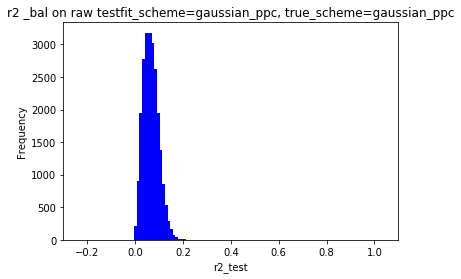

r2 var: 0.0007960585690025304
r2 mean: 0.06207768495709601


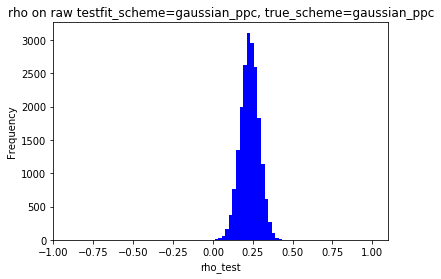

rho var: 0.0033409576186575678
rho mean: 0.24235661191401078



In [43]:
# Visualize one specific plot

#########################################
k_fit_scheme = 0
k_true_scheme = 0
##########################################

fit_scheme = scheme_array[k_fit_scheme]
true_scheme = scheme_array[k_true_scheme]

#r2
metric_name = 'r2'
true_or_raw = 'raw'
sparse_or_bal = '_bal' # balance 
train_or_test = 'test'
exec("metric = %s%s_%s_%s_summary[k_fit_scheme, k_true_scheme, :]" % (metric_name, sparse_or_bal, true_or_raw, train_or_test))

# # We set the negative r2 to the same value
# negative_center = -0.2
# n_negative_values = 0
# if metric_name.find('r2')!=-1:
#     for k, metric_value in enumerate(metric):
#         if metric_value <0:
#             metric[k] = negative_center
#             n_negative_values += 1

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
#ax.bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
ax.set_title(metric_name+' '+sparse_or_bal+' on '+true_or_raw+' '+train_or_test+'fit_scheme='+fit_scheme+', true_scheme='+true_scheme)
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-0.3, 1.1])
plt.show()

print('r2 var: '+str(np.var(metric)))
print('r2 mean: '+str(np.mean(metric)))

fig.savefig("figures_tmp/r2_"+fit_scheme+"_"+true_scheme+"_visualisation.pdf")

# rho
metric_name = 'rho'
true_or_raw = 'raw'
train_or_test = 'test'
exec("metric = %s%s_%s_%s_summary[k_fit_scheme, k_true_scheme]" % (metric_name, sparse_or_bal, true_or_raw, train_or_test))

nbins = 20
width = None
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', rwidth=width)
ax.set_title(metric_name+' on '+true_or_raw+' '+train_or_test+'fit_scheme='+fit_scheme+', true_scheme='+true_scheme)
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-1, 1.1])
plt.show()

print('rho var: '+str(np.var(metric)))
print('rho mean: '+str(np.mean(metric)))
print()

fig.savefig("figures_tmp/rho_"+fit_scheme+"_"+true_scheme+"_visualisation.pdf")

## Plot confusion matrix for simulation 2

r2 on raw test set


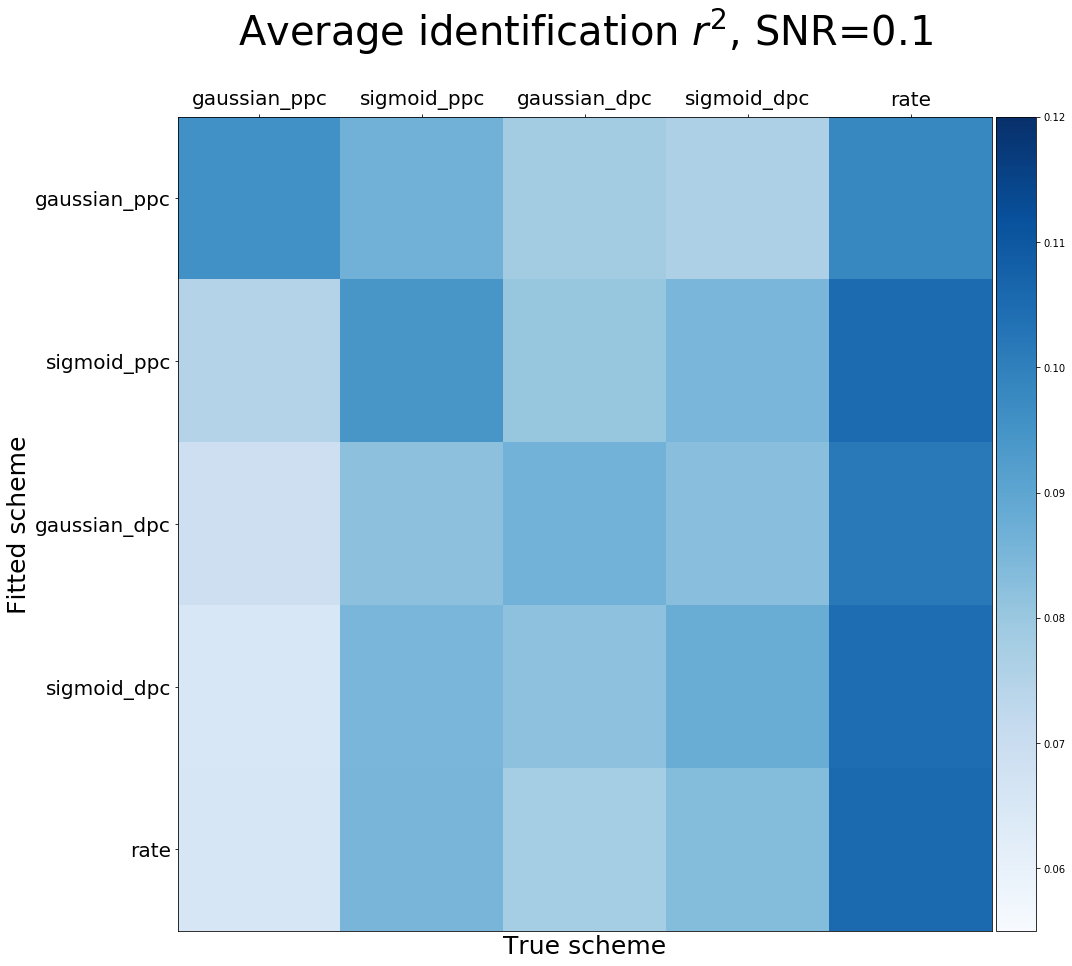

In [52]:
################################
metric_name = 'r2'
true_or_raw = 'raw'
sparse_or_bal = '_sparse'    # '' : all, '_bal' or '_sparse'
train_or_test = 'test'
#################################

print(metric_name+' on '+true_or_raw+' '+train_or_test+' set')

# Visualize the entire confusion matrix
nbins = 20
width = 0.05

# Plot the confusion matrix of the mean
column_labels = scheme_array
row_labels = scheme_array

min_colorbar = 0.055
max_colorbar = 0.12


fig, ax = plt.subplots(figsize=(15,15))
fontsize = 15
exec("metric = copy.deepcopy(%s%s_%s_%s_summary)" % (metric_name, sparse_or_bal, true_or_raw, train_or_test))
# We set the negative r2 to the same value
data = np.mean(metric, axis=2)
heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=min_colorbar, vmax=max_colorbar)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False, fontsize=fontsize+5)
ax.set_yticklabels(row_labels, minor=False, fontsize=fontsize+5)
ax.set_ylabel('Fitted scheme', fontsize=fontsize+10)
ax.set_xlabel('True scheme', fontsize=fontsize+10)
plt.title('Average identification $r^2$, SNR='+str(snr), y=1.08, fontsize=40)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(heatmap, cax=cax)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
fig.tight_layout()
plt.show()

fig.savefig("figures_tmp/"+distrib_type+"_simu2_fit_{}{}_{}_{}S".format(metric_name, sparse_or_bal, true_or_raw, train_or_test), bbox_inches='tight')

In [53]:
# Visualize the percentage of hits

exec("metric = copy.deepcopy(%s%s_%s_%s_summary)" % (metric_name, sparse_or_bal, true_or_raw, train_or_test))


if sparse_or_bal=='_sparse':
    n_trials = n_sparse_fractions*n_subjects*n_sessions
elif sparse_or_bal=='_bal':
    n_trials = n_bal_fractions*n_subjects*n_sessions
else:
    n_trials = n_fractions*n_subjects*n_sessions

hits = np.zeros((n_schemes, n_schemes))
for k_true_scheme in range(n_schemes):
    for k in range(n_trials):
        best_k_fit_scheme = np.argmax(metric[:, k_true_scheme, k])
        #print(best_k_fit_scheme)
        hits[best_k_fit_scheme, k_true_scheme] += 1 

hits = hits/n_trials


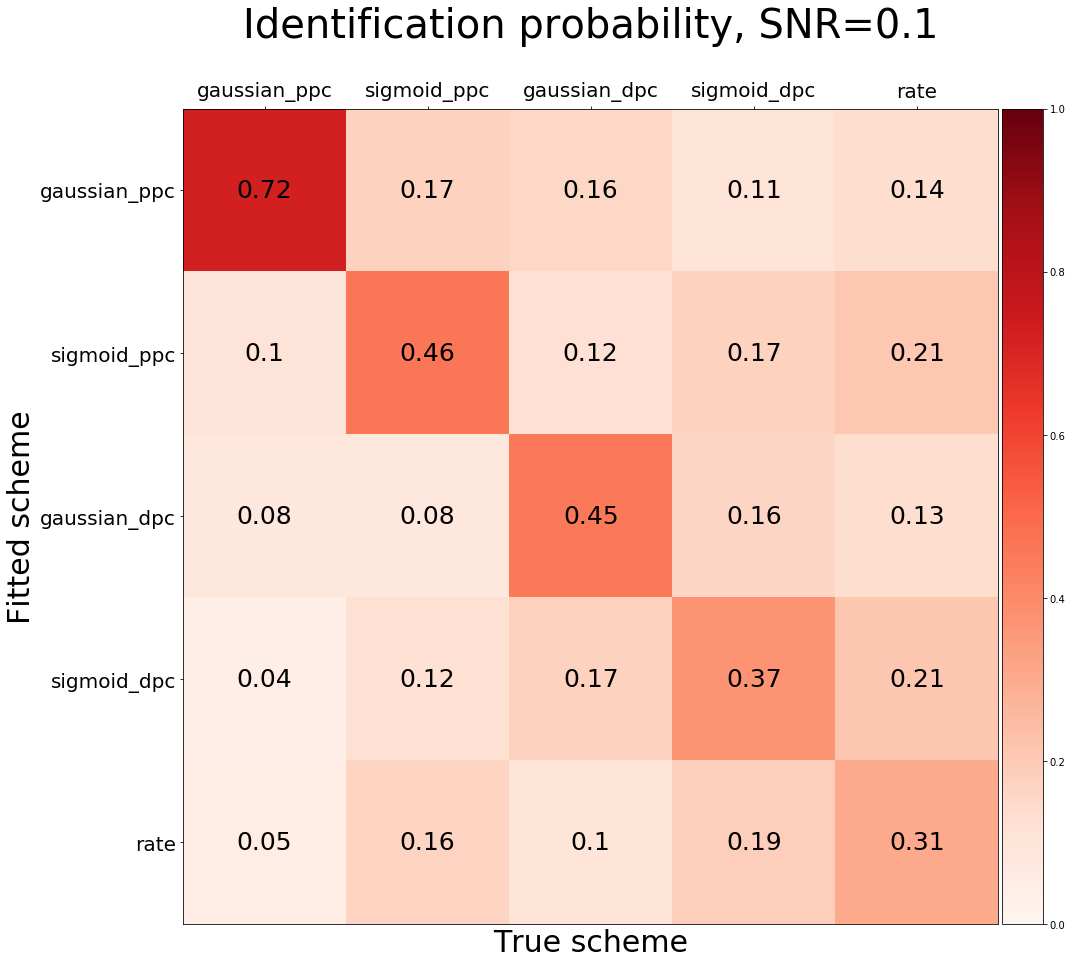

In [54]:
# Plot the identifiability confusion matrix
column_labels = scheme_array
row_labels = scheme_array

fig, ax = plt.subplots(figsize=(15,15))
fontsize = 20

# We set the negative r2 to the same value
data = copy.deepcopy(hits)

min_colormap = 0
max_colormap = 1

heatmap = ax.pcolor(data, cmap=plt.cm.Reds, vmin=min_colormap, vmax=max_colormap)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False, fontsize=fontsize)
ax.set_yticklabels(row_labels, minor=False, fontsize=fontsize)
ax.set_ylabel('Fitted scheme', fontsize=fontsize+10)
ax.set_xlabel('True scheme', fontsize=fontsize+10)
plt.title('Identification probability, SNR='+str(snr), y=1.08, fontsize=40)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(heatmap, cax=cax)

for i in range(n_schemes):
    for j in range(n_schemes):
        c = round(hits[j,i], 2)
        ax.text(i+0.5, j+0.5, str(c), va='center', ha='center', fontsize = 25)

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

fig.tight_layout()
plt.show()

fig.savefig("figures_tmp/"+distrib_type+"_simu2_proba_{}{}_{}_{}S".format(metric_name, sparse_or_bal, true_or_raw, train_or_test), bbox_inches='tight',
           format='pdf')